In [26]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [27]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 20

In [28]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [29]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [30]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 0 1 1 0 1 1 0 0 0 0 1 1 1 1 0 1 0 0 1 0 0 1 1 0 1 0 1 2 0 1 0]


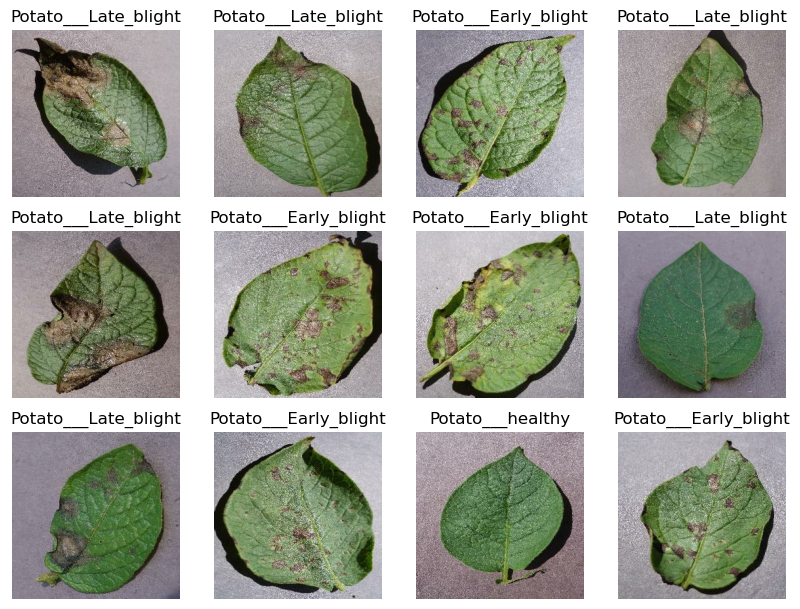

In [31]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(4,4,1+i)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

80% ==> Training
10% ==> Validation
10% ==> Test

In [32]:
len(dataset)

68

In [33]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [34]:
train_ds = dataset.take(54)
len(train_ds)

54

In [35]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [36]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [37]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [38]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [39]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert(train_split + test_split + val_split) ==1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [40]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [41]:
len(train_ds)

54

In [42]:
len(test_ds)

8

In [43]:
len(val_ds)

6

In [44]:
54*32

1728

In [45]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [46]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[1].numpy())

[[[181. 179. 192.]
  [157. 155. 168.]
  [167. 165. 178.]
  ...
  [ 88.  86.  99.]
  [ 90.  88. 101.]
  [ 96.  94. 107.]]

 [[159. 157. 170.]
  [150. 148. 161.]
  [162. 160. 173.]
  ...
  [ 87.  85.  98.]
  [ 90.  88. 101.]
  [ 96.  94. 107.]]

 [[158. 156. 169.]
  [162. 160. 173.]
  [174. 172. 185.]
  ...
  [ 99.  97. 110.]
  [ 94.  92. 105.]
  [ 94.  92. 105.]]

 ...

 [[130. 128. 141.]
  [131. 129. 142.]
  [141. 139. 152.]
  ...
  [105. 102. 111.]
  [104. 101. 110.]
  [101.  98. 107.]]

 [[125. 123. 136.]
  [123. 121. 134.]
  [150. 148. 161.]
  ...
  [104. 101. 110.]
  [105. 102. 111.]
  [108. 105. 114.]]

 [[151. 149. 162.]
  [153. 151. 164.]
  [181. 179. 192.]
  ...
  [117. 114. 123.]
  [116. 113. 122.]
  [121. 118. 127.]]]


In [47]:
## Data Augmentation

In [48]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [49]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [50]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes =3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
    
])

model.build(input_shape=input_shape)

In [51]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [52]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs= EPOCHS
)

Epoch 1/50
54/54 [==============================] - 92s 2s/step - loss: 0.8923 - accuracy: 0.4705 - val_loss: 0.7799 - val_accuracy: 0.4896
Epoch 2/50
54/54 [==============================] - 86s 2s/step - loss: 0.6928 - accuracy: 0.6921 - val_loss: 0.5915 - val_accuracy: 0.7552
Epoch 3/50
54/54 [==============================] - 86s 2s/step - loss: 0.4936 - accuracy: 0.7905 - val_loss: 0.2973 - val_accuracy: 0.8802
Epoch 4/50
54/54 [==============================] - 89s 2s/step - loss: 0.2533 - accuracy: 0.8976 - val_loss: 0.5730 - val_accuracy: 0.8125
Epoch 5/50
54/54 [==============================] - 88s 2s/step - loss: 0.5791 - accuracy: 0.7569 - val_loss: 0.4500 - val_accuracy: 0.7917
Epoch 6/50
54/54 [==============================] - 94s 2s/step - loss: 0.4176 - accuracy: 0.8212 - val_loss: 0.3757 - val_accuracy: 0.8281
Epoch 7/50
54/54 [==============================] - 98s 2s/step - loss: 0.2864 - accuracy: 0.8895 - val_loss: 0.2682 - val_accuracy: 0.8854
Epoch 8/50
54/54 [==

In [ ]:
len(test_ds)

In [ ]:
scores = models.eva(test_ds)
scores

In [ ]:
history.params

In [ ]:
history.history.keys()

In [ ]:
history.history['loss']

In [ ]:
history.history['accuracy']

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Accuracy')
plt.plot(range(EPOCHS), val_loss, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title("loss and val_loss")

plt.show